In [15]:
from multiprocessing import Pool
from ipyparallel import Client



c = Client()  
view = c.load_balanced_view()
c[:].execute("import numpy as np")


<AsyncResult(execute): pending>

In [5]:
import numpy as np
def bsm_mcs_valuation(strike):
    S0 = 100.; T = 1.0; r= 0.05; vola = 0.2; M = 50; I = 20000
    dt = T/M
    rand = np.random.standard_normal((M+1, I))
    S = np.zeros((M+1, I)); S[0] = S0
    for t in range(1, M+1):
        S[t] = S[t-1] * np.exp((r-0.5 *vola **2)*dt + vola * np.sqrt(dt)*rand[t])
    value = (np.exp(-r * T) * np.sum(np.maximum(S[-1]-strike, 0)) / I)
    return value

In [13]:
n = 100
def par_value(n):
    import numpy as np
    strikes = np.linspace(80, 120, n)
    async_results = [view.apply_async(bsm_mcs_valuation, strike) for strike in strikes]
    c.wait(async_results)
    return strikes, async_results

In [16]:
%time strikes, option_values_obj = par_value(n)

CPU times: user 231 ms, sys: 59.1 ms, total: 290 ms
Wall time: 2.79 s


In [17]:
option_values_obj[0].metadata

{'msg_id': '61e27181-fad66fd0daf6cbb1f4e0a354_31185_5',
 'submitted': datetime.datetime(2025, 6, 18, 19, 34, 47, 26612, tzinfo=tzutc()),
 'started': datetime.datetime(2025, 6, 18, 19, 34, 47, 44574, tzinfo=tzutc()),
 'completed': datetime.datetime(2025, 6, 18, 19, 34, 47, 224114, tzinfo=tzutc()),
 'received': datetime.datetime(2025, 6, 18, 19, 34, 47, 235397, tzinfo=datetime.timezone.utc),
 'engine_uuid': '63a8efb4-51d107bd936f81e0fc053ee6',
 'engine_id': 2,
 'follow': [],
 'after': [],
 'status': 'ok',
 'execute_input': None,
 'execute_result': None,
 'error': None,
 'stdout': '',
 'stderr': '',
 'outputs': [],
 'data': {},
 'is_broadcast': False,
 'is_coalescing': False}

In [19]:
option_values_obj[0].result()

24.581989538293954

In [20]:
option_values_par = []
for res in option_values_obj:
    option_values_par.append(res.result())

Text(0, 0.5, 'option value')

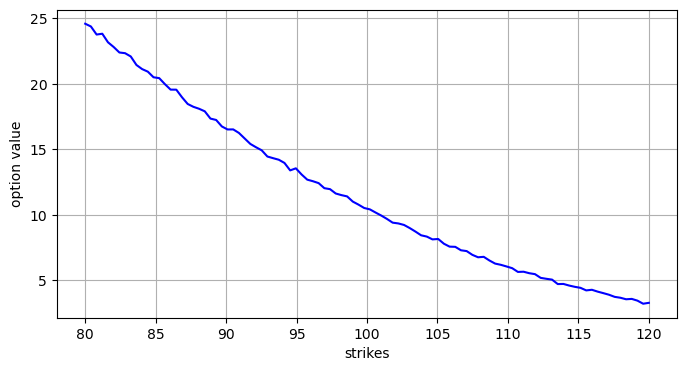

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(strikes, option_values_par, 'b')
plt.grid(True)
plt.xlabel('strikes')
plt.ylabel('option value')
